# Определение стоимости автомобилей

На основании исторических данных: технические характеристики, комплектации и цены автомобилей - необходимо построить модель для определения стоимости автомобилей. Важные критерии: качество предсказания, скорость предсказания, время обучения

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime 
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as lgbm
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error
RANDOM_STATE = 12345

<h3>Открытие файла и обработка пропусков</h3>

Откроем файл и изучим общую информацию о нем

In [2]:
autos = pd.read_csv('/datasets/autos.csv')
display(autos.head(5))
print(autos.info())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB
None


Посмотрим, какие типы кузова есть у volkswagen golf 1993 года регистрации:

In [3]:
display(autos.query('Brand == "volkswagen" and Model == "golf" and RegistrationYear == 1993')['VehicleType'].unique())

array([nan, 'sedan', 'small', 'convertible', 'coupe', 'wagon', 'bus',
       'other'], dtype=object)

<b>Вывод:</b><br>
В данных присутствуют пропуски в следующих столбцах:
<li>VehicleType - тип кузова</li>
<li>Gearbox - коробка передач</li>
<li>Model - модель автомобиля</li>
<li>FuelType - тип топлива</li>
<li>NotRepaired - была машина в ремонте или нет</li>
Все эти данные категориальные. У одной и той же модели автомобиля может быть указана разный тип кузова (это можно видеть выше, где для всех volkswagen golf 1993 выведены все типы кузова), тем более что всегда может отличаться и коробка передач,и тип топлива, и уж тем более невозможно никак угадать, была ли машина в ремонте, не зная этого достоверно. <br>
чтобы не потерять достоверность данных и не снизить качество модели, удалим все пропуски

Посмотрим, какой процент составляют пропущенные значения:

In [4]:
print('Доля пропущенных значения в каждой колонке:')
print(autos.isna().sum()/autos.shape[0])
print()
print('Доля строк с пропущенными значениями: ',sum(autos.apply(lambda x: sum(x.isnull().values), axis = 1)>0)/autos.shape[0])

Доля пропущенных значения в каждой колонке:
DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
NotRepaired          0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

Доля строк с пропущенными значениями:  0.30633322892239445


Как можно видеть, доля строк с пропущенными значениями составляет 30% всего датасета, в основном, за счет довольно больших пропусков в колонках NotRepaired, VehicleType, FuelType, GearBox, Model. Это очень большая доля пропусков, что говорит о том, что можно улучшить методы сбора и хранения информации. Заполнить эти категориальные данные мы не можем, и все они важны в определении стоимости автомобиля, поэтому их все равно придется удалить. После удаления останется еще 245000 строк, на таком объеме данных еще можно проводить анализ.

In [5]:
autos = autos.dropna()
print(autos.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245814 entries, 3 to 354367
Data columns (total 16 columns):
DateCrawled          245814 non-null object
Price                245814 non-null int64
VehicleType          245814 non-null object
RegistrationYear     245814 non-null int64
Gearbox              245814 non-null object
Power                245814 non-null int64
Model                245814 non-null object
Kilometer            245814 non-null int64
RegistrationMonth    245814 non-null int64
FuelType             245814 non-null object
Brand                245814 non-null object
NotRepaired          245814 non-null object
DateCreated          245814 non-null object
NumberOfPictures     245814 non-null int64
PostalCode           245814 non-null int64
LastSeen             245814 non-null object
dtypes: int64(7), object(9)
memory usage: 31.9+ MB
None


Пропуски удалены

<h3>Проверка на наличие в колонках заведомо некорректных значений и скрытых дубликатов</h3>

<h4>Проверка в колонках категориальных данных</h4>

Проверим на наличие в колонках заведомо некорректных значений или скрытых дубликатов:

In [6]:
for column in autos: 
    if column not in ['DateCreated', 'DateCrawled', 'Price','Kilometer','LastSeen','Power','RegistrationYear','RegistrationMonth']:
        print('Колонка: ',column,': ',autos[column].sort_values().unique())

Колонка:  VehicleType :  ['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'wagon']
Колонка:  Gearbox :  ['auto' 'manual']
Колонка:  Model :  ['100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'
 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'
 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'
 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'
 'b_max' 'beetle' 'berlingo' 'bora' 'boxster' 'bravo' 'c1' 'c2' 'c3' 'c4'
 'c5' 'c_klasse' 'c_max' 'c_reihe' 'caddy' 'calibra' 'captiva' 'carisma'
 'carnival' 'cayenne' 'cc' 'ceed' 'charade' 'cherokee' 'citigo' 'civic'
 'cl' 'clio' 'clk' 'clubman' 'colt' 'combo' 'cooper' 'cordoba' 'corolla'
 'corsa' 'cr_reihe' 'croma' 'crossfire' 'cuore' 'cx_reihe' 'defender'
 'delta' 'discovery' 'doblo' 'ducato' 'duster' 'e_klasse' 'elefantino'
 'eos' 'escort' 'espace' 'exeo' 'fabia' 'fiesta' 'focus' 'fores

<b>Вывод:</b><br>
Среди имеющихся значений выявлена странность: В колонке NumberOfPictures все значения - нули. Маловероятно, что данная колонка сможет оказать хоть какое-то значимое влияние на обучение модели. Ее можно удалить.
<br>
Также можно заметить, что в колонке PostalCode содержится большое количество значений, которые, по сути, на цену автомобиля влияния никакого не оказывают. Полагаю, данную колонку из дальнейшей работы можно также исключить
<br>
Все остальные проверенные колонки не содержат заведомо некорректных данных и скрытых дубликатов

In [7]:
autos = autos.drop('NumberOfPictures',axis = 1)
print('Колонка NumberOfPictures удалена')

Колонка NumberOfPictures удалена


In [8]:
autos = autos.drop('PostalCode',axis = 1)
print('Колонка PostalCode удалена')

Колонка PostalCode удалена


<b>Вывод</b><br>
Вполне возможно, что нулями здесь заполнены просто отсутствующие значения. Данные в колонке категориальные, и строк довольно много. Полагаю, эти значения можно оставить

<h4>Анализ значений в колонках 'Price','Kilometer','Power'</h4>

Проверим на наличие заведомо некорректных данных значения в колонках: 'Price','Kilometer','Power'

In [9]:
def print_hist(data,column,head,bins):
    if bins<=0:
        data[column].hist()
    else:
        data[column].hist(bins = bins)
    plt.title('Hist for column '+head)
    plt.ylabel('number of values')
    plt.xlabel(column)
    plt.show()

def print_boxplot(data,column,capture):
    sns.boxplot(y=column,data = data)
    plt.title('Boxplot for '+capture)
    plt.show()

Колонка:  Price
count    245814.000000
mean       5125.346717
std        4717.948673
min           0.000000
25%        1499.000000
50%        3500.000000
75%        7500.000000
max       20000.000000
Name: Price, dtype: float64


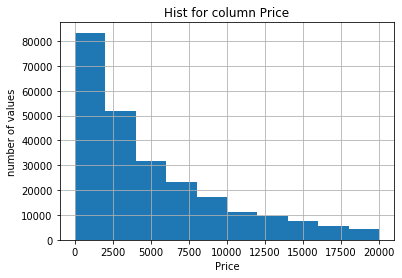

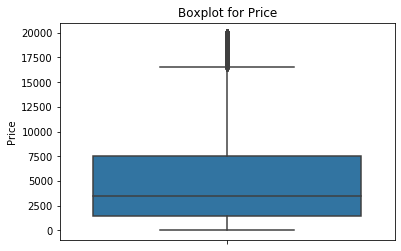

----------------------------------------------------------------------------------------------------------------

Колонка:  Kilometer
count    245814.000000
mean     127296.716216
std       37078.820368
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64


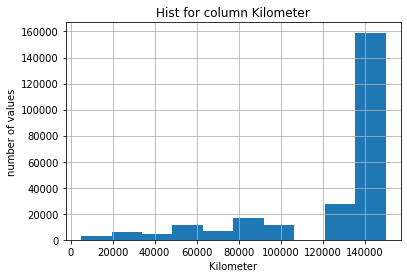

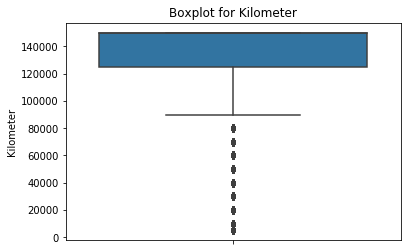

----------------------------------------------------------------------------------------------------------------

Колонка:  Power
count    245814.000000
mean        119.970884
std         139.387116
min           0.000000
25%          75.000000
50%         110.000000
75%         150.000000
max       20000.000000
Name: Power, dtype: float64


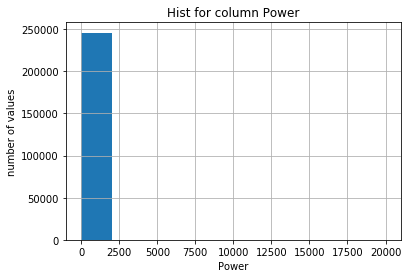

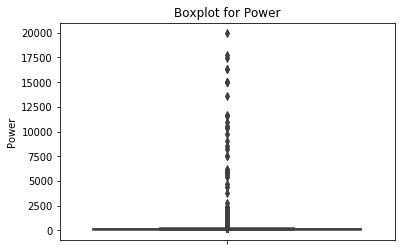

----------------------------------------------------------------------------------------------------------------

Колонка:  RegistrationYear
count    245814.000000
mean       2002.918699
std           6.163765
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2018.000000
Name: RegistrationYear, dtype: float64


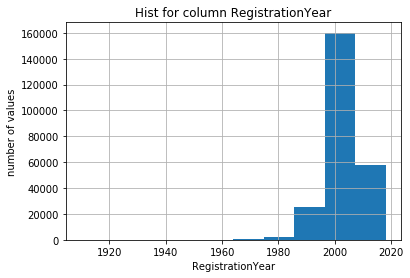

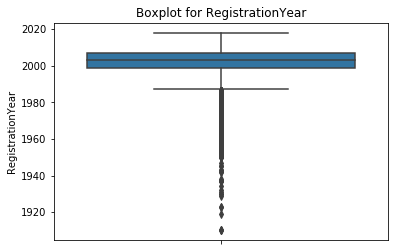

----------------------------------------------------------------------------------------------------------------

Колонка:  RegistrationMonth
count    245814.000000
mean          6.179701
std           3.479519
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: RegistrationMonth, dtype: float64


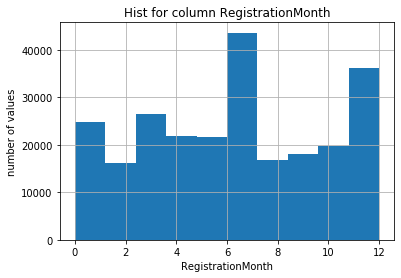

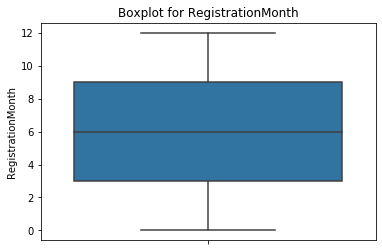

----------------------------------------------------------------------------------------------------------------



In [10]:
for column in ['Price','Kilometer','Power','RegistrationYear','RegistrationMonth']:
    print('Колонка: ',column)
    print(autos[column].describe())
    print_hist(autos,column,column,0)
    print_boxplot(autos,column,column)
    print('--------------'*8)
    print()

<b>Вывод</b><br>
В колонке <b>Price</b> найдены нулевые значения. В целом данные в этой колонке распределены следующим образом: чем ниже цена, тем больше предложений.Также есть аномально большие значения сыше 17000 евро. Средняя цена составляет 5200 евро, медианная - 3500. Стандартное отклонение также говорит о достаточно большом разбросе данных <br>
В колонке <b>Kilometer</b> достаточно большое количество данных о машинах с большим пробегом. Только 25% машин с пробегом менее 125000 км. Все значения ниже 90000 км выходят за границы "усов" диаграммы размаха, то есть статистически они могут быть определены как выбросы<br>
В колонке <b>Power</b> большое количество "выбросов"-единичных значений. Все основные значения сконцентрированы в интервале (0,2500). Однако, в данной колонке также найдены нулевые значения, что вряд-ли соответсвтует <br>
В колонке <b>RegistrationYear</b> видно, что большинство автомобилей - 1999-2008 годов регистрации, также довольно много машин более поздних лет регистрации. Однако довольно много единичных экзмепляров младше 1990 года регистрации  <br>
В колонке <b>RegistrationMonth</b> видно, что чаще всего автомобили регистрируют в июне-июле и ноябре-декабре. Можно также видеть, что в данной колонке присутствуют значения месяцев 0-12. То есть 13 значений. Рассмотрим их ниже<br> 
В колонках price и power найдены строки с нулевым значением, вероятно также есть значения, близкие к 0. Рассмотрим подробнее эти колонки с низкими значениями.

<h5>Анализ значений в колонках Price</h5>

In [11]:
display(autos.query('Price == 0').head(5))
print('Количество строк с нулевым значением Price: ',autos.query('Price == 0').shape[0])

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,LastSeen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,2016-03-25 16:47:58
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11 00:00:00,2016-03-12 23:47:10
579,2016-03-27 11:37:43,0,sedan,1996,manual,170,5er,150000,0,petrol,bmw,no,2016-03-27 00:00:00,2016-03-27 11:37:43
615,2016-04-05 06:36:35,0,sedan,1998,manual,75,polo,150000,0,petrol,volkswagen,yes,2016-04-05 00:00:00,2016-04-07 10:44:39
859,2016-03-09 08:53:31,0,wagon,2009,manual,170,a6,150000,1,gasoline,audi,yes,2016-03-09 00:00:00,2016-03-09 10:40:29


Количество строк с нулевым значением Price:  3386


<b>Вывод</b><br>
Строки с нулевой ценой - это строки, которые могут только приводить к переобучению модели и ухудшению ее качества. Совершенно неважно, были ли эти машины подарены или просто отсутствует информация об их ценах, в обучении модели такие строки участвовать не должны. Поэтому их лучше удалить. Проверим также есть ли еще заведомо очень низкие значения цены:

Price < 500


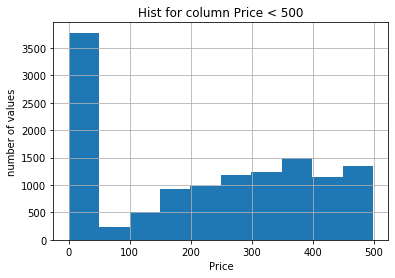

--------------------------------------------------------------------------------------------------------
Price < 100


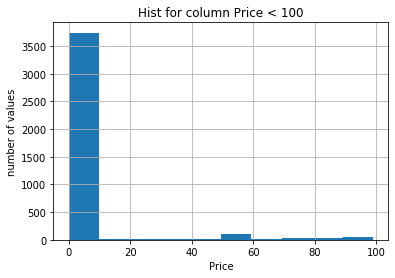

In [12]:
print('Price < 500')
print_hist(autos.query('Price < 500'),'Price','Price < 500',0)
print('-------------'*8)
print('Price < 100')
print_hist(autos.query('Price < 100'),'Price','Price < 100',0)

<b>Вывод</b><br>
Можно видеть, что присутствует достаточно большое количество автомобилей с ценой ниже 10 евро. В принципе цена на автомобиль ниже 10 евро кажется крайне маловероятной. Будет разумным удалить все строки, где цена автомобиля не превышает 10 евро. Также рассмотрим строки, где цена автомобиля не превышает 100 долларов. Такая цена также кажется маловероятной, но все-же стоит их проанализировать

Проверим, какое количество значений предстоит удалить:

In [13]:
print('Доля нулевых значениий в колонке Price: ',autos.query('Price == 0').shape[0]/autos.shape[0])
print('Доля значениий в колонке Price <= 10: ',autos.query('Price <= 10').shape[0]/autos.shape[0])

Доля нулевых значениий в колонке Price:  0.013774642615961662
Доля значениий в колонке Price <= 10:  0.015267641387390465


Можно видеть, что удалению подлежит 1,5% данных, то есть около 3700 строк. Возможно, стоит рассмотреть идею о контроле вводимых значений в поле "Цена"

266


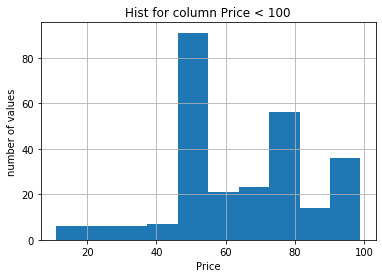

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,LastSeen
943,2016-04-03 14:39:43,98,small,1997,manual,53,swift,150000,7,petrol,suzuki,no,2016-04-03 00:00:00,2016-04-05 13:18:15
2687,2016-03-20 13:59:15,90,small,2001,manual,0,twingo,150000,0,petrol,renault,yes,2016-03-20 00:00:00,2016-03-20 14:40:35
3071,2016-03-24 19:57:53,30,sedan,1995,manual,75,polo,150000,0,petrol,volkswagen,no,2016-03-24 00:00:00,2016-04-05 13:16:29
5091,2016-03-21 11:37:01,60,small,1994,manual,0,micra,150000,3,petrol,nissan,yes,2016-03-21 00:00:00,2016-03-29 20:46:19
5289,2016-03-09 11:53:59,75,sedan,1998,manual,75,escort,150000,1,petrol,ford,yes,2016-03-09 00:00:00,2016-03-10 18:16:09


In [14]:
autos = autos.query('Price > 10')
print(autos.query('Price < 100').shape[0])
print_hist(autos.query('Price < 100'),'Price','Price < 100',0)
display(autos.query('Price < 100').head(5))

<b>Вывод</b><br>
Можно видеть, что в датасете по-прежнему есть 266 строк, где цена автомобиля не превышает 100 евро. Совершенно безболезненно можно удалить строки, где цена за автомобиль не превышает 45 евро. Такая цена кажется практически нереальной для цены на автомобиль, и таких строк немного

In [15]:
autos = autos.query('Price > 45')
print('Строки со значением Price <=45 удалены')

Строки со значением Price <=45 удалены


<h5>Анализ значений в колонке Power</h5>

В колонке Power достаточно большое количество аномальных значений. Выведем более подробные диаграммы:

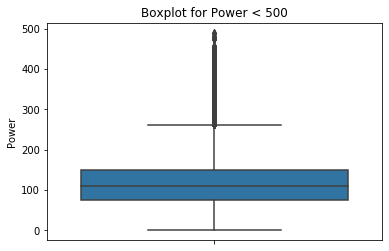

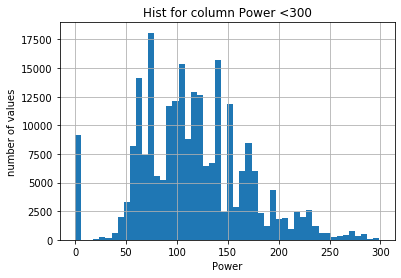

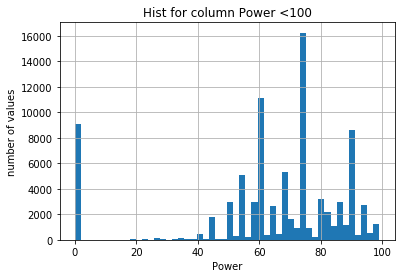

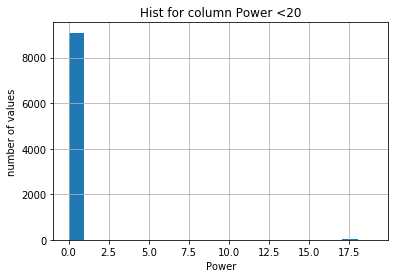

In [16]:
print_boxplot(autos.query('Power<500'),'Power','Power < 500')
print_hist(autos.query('Power<300'),'Power','Power <300',50)
print_hist(autos.query('Power<100'),'Power','Power <100',50)
print_hist(autos.query('Power<20'),'Power','Power <20',20)

В колонке Power около 9000 строк со значением 0. Посмотрим, что это за строки и что с ними можно сделать

In [17]:
display(autos.query('Power == 0').head(5))
print('Количество нулевых значений: ',autos.query('Power == 0').shape[0])

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,LastSeen
55,2016-03-26 10:39:35,550,wagon,1999,manual,0,astra,150000,8,gasoline,opel,yes,2016-03-26 00:00:00,2016-04-01 23:17:27
70,2016-03-08 01:36:42,800,small,1993,manual,0,polo,150000,3,petrol,volkswagen,no,2016-03-08 00:00:00,2016-04-05 23:46:00
98,2016-03-11 19:00:25,4290,bus,2008,manual,0,combo,150000,2,gasoline,opel,no,2016-03-11 00:00:00,2016-04-05 22:45:32
158,2016-04-01 16:06:24,800,sedan,1993,manual,0,golf,10000,9,petrol,volkswagen,yes,2016-04-01 00:00:00,2016-04-07 11:17:07
166,2016-03-16 12:53:29,300,wagon,1998,manual,0,v40,150000,6,petrol,volvo,no,2016-03-16 00:00:00,2016-03-25 10:18:16


Количество нулевых значений:  9094


Проверим, отличаются ли значения в колонке Power для автомобилей одной и той же марки и бренда

In [18]:
display(autos.query('Brand == "opel" and Model == "combo"').head(5))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,LastSeen
98,2016-03-11 19:00:25,4290,bus,2008,manual,0,combo,150000,2,gasoline,opel,no,2016-03-11 00:00:00,2016-04-05 22:45:32
127,2016-03-16 18:37:43,1100,bus,2003,manual,75,combo,150000,3,gasoline,opel,no,2016-03-16 00:00:00,2016-03-24 11:46:38
1093,2016-04-04 13:25:44,4500,other,2012,manual,90,combo,150000,1,gasoline,opel,yes,2016-04-04 00:00:00,2016-04-05 12:16:01
2533,2016-03-13 00:25:21,1995,bus,2003,manual,95,combo,150000,1,petrol,opel,no,2016-03-12 00:00:00,2016-03-14 14:12:10
2591,2016-03-14 12:36:24,1650,wagon,2003,manual,65,combo,30000,10,gasoline,opel,no,2016-03-14 00:00:00,2016-03-23 12:46:06


<b>Вывод</b><br>
Значения в колонке Power - категориальные, и для разных автомобилей одного и того же бренда и марки (даже одного и того же года) могут отличаться, поэтому заполнить их какими-либо значениями нельзя. А нулевые значения - заведомо некорректные, они могут приводить к переобучению и ухудшению качества модели (тем более в таких количествах). Так что их лучше удалить

Строки со значением Power == 0 удалены


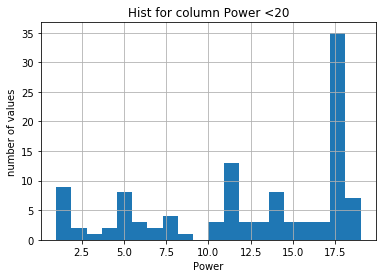

In [19]:
autos = autos.query('Power > 0')
print('Строки со значением Power == 0 удалены')
print_hist(autos.query('Power<20'),'Power','Power <20',20)

Можно видеть, что в колонке все еще содержатся очень низкие значения мощности двигателя. Особенно интересны значения ниже 10 л.с.: такие значения были свойственны первым автомомбилям и некоторым автомобилям начала 20 века. Значения 10-20 лс еще также могли встречаться в начале 20 века, а также немного позже в автомобилях с мотоциклетным двигателем.

In [20]:
display(autos.query('Power < 10').sort_values(by = 'RegistrationYear').head(10))
print('Количество колонок с Power < 10:',autos.query('Power < 10').shape[0])

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,LastSeen
324049,2016-03-16 17:57:29,8750,convertible,1923,manual,8,c3,5000,1,petrol,citroen,no,2016-03-16 00:00:00,2016-04-04 22:16:07
52952,2016-03-07 19:53:06,990,coupe,1974,manual,1,kadett,5000,3,petrol,opel,yes,2016-03-07 00:00:00,2016-03-10 04:44:22
196897,2016-04-05 11:37:54,500,small,1975,manual,1,polo,150000,8,petrol,volkswagen,no,2016-04-05 00:00:00,2016-04-05 11:37:54
274968,2016-03-08 11:38:54,200,sedan,1992,manual,1,golf,100000,12,petrol,volkswagen,yes,2016-03-08 00:00:00,2016-03-10 02:46:26
59478,2016-03-28 18:40:10,999,convertible,1995,manual,5,punto,125000,0,petrol,fiat,no,2016-03-28 00:00:00,2016-04-01 03:18:18
166634,2016-03-29 14:46:45,850,small,1996,manual,6,polo,150000,5,petrol,volkswagen,no,2016-03-29 00:00:00,2016-04-03 23:16:28
94319,2016-03-22 13:38:51,300,convertible,1997,manual,1,golf,5000,4,gasoline,volkswagen,yes,2016-03-22 00:00:00,2016-04-04 01:15:36
146998,2016-03-30 12:54:27,650,bus,1998,manual,5,kangoo,150000,6,petrol,renault,no,2016-03-30 00:00:00,2016-03-30 12:54:27
44179,2016-04-02 17:52:18,500,small,1998,auto,7,1_reihe,100000,11,petrol,peugeot,no,2016-04-02 00:00:00,2016-04-02 17:52:18
161438,2016-03-23 21:06:33,900,wagon,1998,manual,1,other,5000,5,other,fiat,no,2016-03-23 00:00:00,2016-04-07 00:15:56


Количество колонок с Power < 10: 32


В этих данных можно сразу увидеть некоторые ошибки. Во-первых, автомобиль opel kadett 1974 имел мощность двигателя не менее 45 л.с., да и в принципе такие маленькие значения мощности (1,5,6) двигателя для автомобилей второй половины 20 века - как минимум странно, автомобили были гораздо более мощными. Очевидно, что это данные с ошибкой. 
Проверим, для автомобилей каких лет указана столь низкая мощность двигателя

In [21]:
pd.pivot_table(data = autos.query('Power <= 10')[['Power','RegistrationYear','Price']], index = 'RegistrationYear', columns = 'Power', aggfunc = 'count',fill_value ='-')

Price                           
Power               1  2  3  4  5  6  7  8  9  10
RegistrationYear                                 
1923                 -  -  -  -  -  -  -  1  -  -
1974                 1  -  -  -  -  -  -  -  -  -
1975                 1  -  -  -  -  -  -  -  -  -
1992                 1  -  -  -  -  -  -  -  -  -
1995                 -  -  -  -  1  -  -  -  -  1
1996                 -  -  -  -  -  1  -  -  -  -
1997                 1  -  -  -  -  -  -  -  -  -
1998                 2  -  -  -  1  -  1  -  -  -
1999                 -  -  -  -  -  1  -  1  1  -
2000                 -  -  -  -  -  -  1  -  -  1
2001                 -  -  -  -  2  -  -  -  -  -
2002                 1  -  -  -  1  -  -  -  -  -
2003                 -  -  -  1  -  -  -  -  -  -
2004                 1  2  -  1  1  -  -  -  -  -
2005                 1  -  1  -  -  -  -  -  -  1
2006                 -  -  -  -  1  -  -  -  -  -
2011                 -  -  -  -  -  1  -  1  -  -
2012                 -  -  -  -  1  -  -  1  -  -

<b>Вывод</b><br>
Можно видеть, что для автомобилей с годом регистрации не ранее 1974 года встречаются автомомбили с очень низкой мощностью мотора. Для автомобиля citroen c3 1923 года мощность в 8 лс еще может быть правдоподобной, но для автомобиля 2005 года мощность в 1 лс - нет. Полагаю, будет верным удалить данные об автомоблиях, зарегистрированных после 1923 года с мощностью мотора менее 10 лс

Строки со значением Power < 10 and RegistrationYear > 1923 == 0 удалены


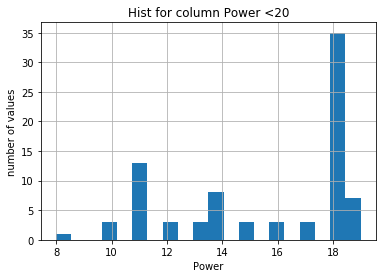

In [22]:
autos = autos.query('not (Power < 10 and RegistrationYear > 1923)')
print('Строки со значением Power < 10 and RegistrationYear > 1923 == 0 удалены')
print_hist(autos.query('Power<20'),'Power','Power <20',20)

<h5>Анализ значений в колонке RegistrationMonth</h5>

Ранее было видно, что в колонке RegistrationMonth указаны значения от 0 до 12 включительно. Посмотрим, что за нулевые значения и сколько их

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,LastSeen
80,2016-04-01 22:39:35,250,wagon,2000,manual,155,156,150000,0,petrol,alfa_romeo,yes,2016-04-01 00:00:00,2016-04-05 20:18:14
303,2016-03-24 14:56:28,800,coupe,1997,manual,125,a3,150000,0,petrol,audi,yes,2016-03-24 00:00:00,2016-03-29 00:44:57
559,2016-03-19 14:36:21,2150,small,2008,manual,64,getz,100000,0,petrol,hyundai,no,2016-03-19 00:00:00,2016-03-21 08:59:43
578,2016-03-20 16:44:16,4000,bus,2001,manual,115,sharan,150000,0,gasoline,volkswagen,no,2016-03-20 00:00:00,2016-03-27 04:44:28
636,2016-04-02 22:48:13,1480,small,2003,manual,58,twingo,150000,0,petrol,renault,no,2016-04-02 00:00:00,2016-04-02 22:48:13


Количество строк:  5549


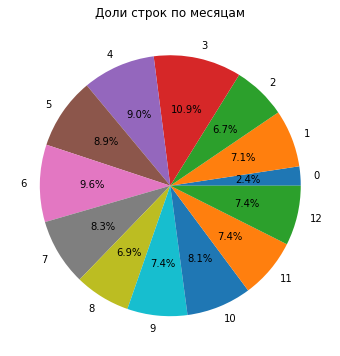

In [23]:
display(autos.query('RegistrationMonth == 0').head(5))
print('Количество строк: ',autos.query('RegistrationMonth == 0').shape[0])

#Построим круговую диаграмму
autos.groupby('RegistrationMonth').size().plot(kind='pie', subplots=True, figsize=(6,6), autopct='%1.1f%%')
plt.title("Доли строк по месяцам")
plt.ylabel("")
plt.show()

<b>Вывод</b><br>
2,4% строк содержат значение колонки RegistrationMonth = 0. Вероятнее всего, нули здесь указаны для заполнения пропущенных значений. RegistrationMonth - категориальный признак, наибольшая концентрация  - с марта по июнь. В остальные месяцы количество регистраций примерно одинаковое. Да и в марте-июне не слишком большие отличия. Обычно месяц регистрации очень мало влияет на цену автомобиля, так что вряд-ли этот признак можно назвать существенным. Однако эти 5,5 тыс строк могут содержать другие важные для модели данные. Так что оставим эту колонку без изменений

<h4>Анализ значений в колонках даты-времени</h4>

Датасет содержит следующие признаки в формате даты-времени:<br> 
<li>DateCrawled - дата скачивания анкеты из базы, </li>
<li>DateCreated - дата создания анкеты, </li>
<li>LastSeen - дата последней активности пользователя</li>
Сами по себе эти признаки вряд-ли оказывают какое-либо существенное влияние на стоимость автомобиля. Однако на стоимость автомобиля может повлиять год продажи автомобиля: во-первых, из-за "возраста" автомомбиля, во-вторых, из-за меняющейся ситуации на рынке. Можно из имеющихся данных получить предполагаемый год продажи автомобиля, а сами эти колонки исключить из построения моделей

In [24]:
def make_dt_print_mm(data,column):
    data[column] = pd.to_datetime(autos[column]).dt.year
    print(column,': min - ',data[column].min(),'; max - ',data[column].max())
    return data

In [25]:
date_cols = ['DateCreated','DateCrawled','LastSeen']
for column in date_cols:
    autos = make_dt_print_mm(autos,column)
autos['SalesYear'] = autos[['DateCreated','DateCrawled','LastSeen']].max(axis = 1)
print('SalesYear: min - ',autos['SalesYear'].min(),'; max - ',autos['SalesYear'].max())
autos = autos.drop(['DateCreated','DateCrawled','LastSeen'], axis = 1)
display(autos.head(5))

DateCreated : min -  2015 ; max -  2016
DateCrawled : min -  2016 ; max -  2016
LastSeen : min -  2016 ; max -  2016
SalesYear: min -  2016 ; max -  2016


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,SalesYear
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016
10,2000,sedan,2004,manual,105,3_reihe,150000,12,petrol,mazda,no,2016


<b>Вывод</b><br>
Как можно видеть, год продаж получился одинаковым для всех строк. Это не очень информативно для построения модели. Можно попробовать вывести признак "возраст автомобиля" = SalesYear - RegistrationYear. Тогда SalesYear можно будет убрать.

In [26]:
autos['AutoAge'] = autos['SalesYear'] -  autos['RegistrationYear']
autos = autos.drop(['SalesYear'], axis = 1)
display(autos.head(5))

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,AutoAge
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,15
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,8
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,21
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,12
10,2000,sedan,2004,manual,105,3_reihe,150000,12,petrol,mazda,no,12


Данные готовы к построению моделей

<h3>Преобразование данных и разделение на выборки</h3>

Стандартизируем данные:

In [27]:
#зададим перечень категориальных признаков:
cat_features = ['VehicleType','Gearbox','Model','FuelType','Brand','NotRepaired']
num_features = ['RegistrationYear','Power','Kilometer','RegistrationMonth','AutoAge']

scaler = StandardScaler()
autos[num_features] = scaler.fit_transform(autos[num_features])
display(autos.head(5))

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,AutoAge
3,1500,small,-0.344851,manual,-0.362281,golf,0.620073,-0.064146,petrol,volkswagen,no,0.344851
4,3600,small,0.807272,manual,-0.405891,fabia,-0.998573,0.225507,gasoline,skoda,no,-0.807272
5,650,sedan,-1.332385,manual,-0.166032,3er,0.620073,1.094465,petrol,bmw,yes,1.332385
6,2200,convertible,0.148916,manual,-0.115152,2_reihe,0.620073,0.515159,petrol,peugeot,no,-0.148916
10,2000,sedan,0.148916,manual,-0.144226,3_reihe,0.620073,1.673770,petrol,mazda,no,-0.148916


Преобразуем категориальные данные методом OHE для ряда моделей:

In [28]:
autos_ohe = pd.get_dummies(autos,drop_first=True)
display(autos_ohe.head(5))
print('Размер датафрейма после применения техники OHE:',autos_ohe.shape)

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,AutoAge,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,...,Brand_seat,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_yes
3,1500,-0.344851,-0.362281,0.620073,-0.064146,0.344851,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,3600,0.807272,-0.405891,-0.998573,0.225507,-0.807272,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,650,-1.332385,-0.166032,0.620073,1.094465,1.332385,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
6,2200,0.148916,-0.115152,0.620073,0.515159,-0.148916,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,2000,0.148916,-0.144226,0.620073,1.673770,-0.148916,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Размер датафрейма после применения техники OHE: (232911, 307)


Разделим выборку на обучающую и тестовую:

In [29]:
def make_train_test(data,target_col):
    #print(data.info())
    #print(target_col)
    features = data.drop(target_col,axis=1)
    target = data[target_col]
    features_train,features_test,target_train, target_test = train_test_split(features,target,test_size=0.2,random_state = RANDOM_STATE)
    return features_train,features_test,target_train, target_test

autos_features_train, autos_features_test, autos_target_train, autos_target_test  = make_train_test(autos,'Price')
autos_features_train_ohe, autos_features_test_ohe, autos_target_train_ohe, autos_target_test_ohe  = make_train_test(autos_ohe,'Price')
print('Данные успешно разделены на обучающую и тестовую выборки.')

Данные успешно разделены на обучающую и тестовую выборки.


## Обучение моделей

<h3>Создание моделей</h3>

Создадим датасет для сравнения результатов работы разных моделей:

In [30]:
def add_to_model_types_compare(mtc,mod_name,best_params,best_scores,test_score,time):
    mtc = mtc.append({'model_name':mod_name,'best_params':best_params,'best Train score ':best_scores,'RMSE Test Data':test_score,'fit time':time},ignore_index = True)
    display(mtc)
    return mtc
model_types_compare = pd.DataFrame()
print('Датасет для сравнения моделей успешно создан')

Датасет для сравнения моделей успешно создан


Создадим функцию для подбора гиперпараметров и выбора наилучшей модели

In [31]:
def find_best_model(model,params,features_train,target_train,features_test,target_test,mtc,mod_name,mod_lib,cat_features):
    grd = GridSearchCV(estimator = model, param_grid = params, 
                               cv = 3, n_jobs = -1, scoring = 'neg_mean_squared_error')
    if mod_lib == 'CB':
        grd.fit(features_train, target_train,cat_features = cat_features)
    elif mod_lib == 'SL':
        grd.fit(features_train, target_train)
    elif mod_lib == 'LGBM':
        grd.fit(features_train, target_train,categorical_feature = 'auto')
    bs = np.sqrt((-1)*grd.best_score_)
    bp = grd.best_params_
    est = grd.best_estimator_
    pred = est.predict(features_test)
    rmse = np.sqrt(mean_squared_error(target_test,pred))
    time = grd.refit_time_
    mtc = add_to_model_types_compare(mtc,mod_name,bp,bs,rmse,time)
    return mtc,est,bp

<h4>Обучение моделей дерева решений, лес решений и линейной регрессии</h4>

<b>DecisionTreeRegressor</b>

In [32]:
dec_tree = DecisionTreeRegressor()
depth_list = [i for i in range(1,30)]
params = {'max_depth':depth_list,'criterion':['mse'],'random_state':[RANDOM_STATE]}
model_types_compare ,best_DT,best_DT_BP= find_best_model(dec_tree,params,autos_features_train_ohe, autos_target_train_ohe, autos_features_test_ohe, autos_target_test_ohe,model_types_compare,'DecisionTree','SL',[])


,RMSE Test Data,best Train score,best_params,fit time,model_name
0,1828.976681,1871.997096,"{'criterion': 'mse', 'max_depth': 16, 'random_...",4.127833,DecisionTree


In [33]:
print('Параметры полученной модели')
best_DT.get_params()

Параметры полученной модели


{'criterion': 'mse',
 'max_depth': 16,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 12345,
 'splitter': 'best'}

Полученная модель дерева решений достигает наилучшего значения функции потрерь при значении параметра max_depth = 16. Можно видеть, что значение RMSE на тестовых данных лучше, чем на обучающих. Время обучения модели - достаточно относительно небольшое. Посмотрим, каких значений удастся добиться на других моделях

<b>RandomForestRegressor</b>

In [34]:
estim_list = [i for i in range(1,20,5)]
depth_list = [i for i in range(1,15)]
params = {'n_estimators':estim_list, 'max_depth':depth_list,'criterion':['mse'],'random_state':[RANDOM_STATE]}
rfc = RandomForestRegressor()    
model_types_compare, best_RF,best_RF_BP = find_best_model(rfc,params,autos_features_train_ohe, autos_target_train_ohe, autos_features_test_ohe, autos_target_test_ohe,model_types_compare,'RandomForest','SL',[])


,RMSE Test Data,best Train score,best_params,fit time,model_name
0,1828.976681,1871.997096,"{'criterion': 'mse', 'max_depth': 16, 'random_...",4.127833,DecisionTree
1,1696.588363,1691.338903,"{'criterion': 'mse', 'max_depth': 14, 'n_estim...",38.663172,RandomForest


In [35]:
print('Параметры полученной модели')
best_RF.get_params()

Параметры полученной модели


{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 14,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 16,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 12345,
 'verbose': 0,
 'warm_start': False}

Можно видеть, что значение функции потерь у модели случайного леса значительно ниже, чем у модели дерева решений. Значение функции RMSE на тестовых данных датсаточно близко к достигнутому минимальному значению на обучающих данных. Однако время обучения многократно выше, чем у модели дерева решений. Наилучшее значение функции потерь достигается при значении гиперпараметров max_depth = 14 и n_estimators = 16 

<b>LinearRegression</b>

In [36]:
params = {'normalize':[True,False]}
lr = LinearRegression() 
model_types_compare, best_LR,best_LR_BP = find_best_model(lr,params,autos_features_train_ohe, autos_target_train_ohe, autos_features_test_ohe, autos_target_test_ohe,model_types_compare,'Linear Regression','SL',[])


,RMSE Test Data,best Train score,best_params,fit time,model_name
0,1828.976681,1.871997e+03,"{'criterion': 'mse', 'max_depth': 16, 'random_...",4.127833,DecisionTree
1,1696.588363,1.691339e+03,"{'criterion': 'mse', 'max_depth': 14, 'n_estim...",38.663172,RandomForest
2,2708.958052,1.134442e+12,{'normalize': False},14.100979,Linear Regression


In [37]:
print('Параметры полученной модели')
best_LR.get_params()

Параметры полученной модели


{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

Значение RMSE на модели линейной регрессии значительно выше, чем у предшествующих двух значений. Время обучения также достаточно большое. Наилучшее значение функции потрерь достигается при значении гиперпараметра normalize = False. Вполне возможно, потому что данные уже были стандартизированы. Для ускорения работы модели можно было использовать параметр n_jobs = -1, однако на качество модели это не повлияло бы, а оно значительно хуже, чем у предыдущих моделей. 

<h4>Обучение бустинговых моделей</h4>

<b>CatBoostRegressor</b>

In [38]:
params = {'loss_function':['RMSE'],'learning_rate':[0.07,0.3],'n_estimators':[10,15,30],'random_seed':[RANDOM_STATE],'verbose':[1000]}
cbc = CatBoostRegressor()

model_types_compare, best_CBC,best_CBC_BP = find_best_model(cbc,params,autos_features_train, autos_target_train,autos_features_test, autos_target_test,model_types_compare,'CatBoostRegressor','CB',cat_features)


0:	learn: 4492.1895791	total: 105ms	remaining: 946ms
9:	learn: 3141.8136892	total: 1.2s	remaining: 0us
0:	learn: 4513.8601144	total: 52.8ms	remaining: 476ms
9:	learn: 3160.4969317	total: 1.15s	remaining: 0us
0:	learn: 4493.8888955	total: 31.2ms	remaining: 281ms
9:	learn: 3131.6723522	total: 1.13s	remaining: 0us
0:	learn: 4492.1895791	total: 93.3ms	remaining: 1.31s
14:	learn: 2742.1253714	total: 1.78s	remaining: 0us
0:	learn: 4513.8601144	total: 24.1ms	remaining: 338ms
14:	learn: 2756.5502293	total: 1.62s	remaining: 0us
0:	learn: 4493.8888955	total: 85.4ms	remaining: 1.2s
14:	learn: 2733.5577509	total: 1.78s	remaining: 0us
0:	learn: 4492.1895791	total: 59.9ms	remaining: 1.74s
29:	learn: 2150.4337281	total: 3.44s	remaining: 0us
0:	learn: 4513.8601144	total: 65.5ms	remaining: 1.9s
29:	learn: 2166.3754681	total: 3.46s	remaining: 0us
0:	learn: 4493.8888955	total: 78ms	remaining: 2.26s
29:	learn: 2156.7226036	total: 3.76s	remaining: 0us
0:	learn: 3776.6781107	total: 49.2ms	remaining: 443ms
9

,RMSE Test Data,best Train score,best_params,fit time,model_name
0,1828.976681,1.871997e+03,"{'criterion': 'mse', 'max_depth': 16, 'random_...",4.127833,DecisionTree
1,1696.588363,1.691339e+03,"{'criterion': 'mse', 'max_depth': 14, 'n_estim...",38.663172,RandomForest
2,2708.958052,1.134442e+12,{'normalize': False},14.100979,Linear Regression
3,1797.701019,1.776480e+03,"{'learning_rate': 0.3, 'loss_function': 'RMSE'...",6.385439,CatBoostRegressor


In [39]:
print('Параметры полученной модели')
best_CBC.get_params()

Параметры полученной модели


{'loss_function': 'RMSE',
 'learning_rate': 0.3,
 'n_estimators': 30,
 'random_seed': 12345,
 'verbose': 1000}

Наилучшее значение функции потерь в в модели CatBoostRegressor достигается при learning_rate = 0.3, n_estinators = 30 и depth = None (по умолчанию для данной модели). Значение RMSE на обучающих данных очень близко к значению RMSE на тестовых, что говорит о высокой точности модели. В целом значение RMSE несколько ниже, чем у RandomForestRegressor,  но скорость обучения выше почти в 7 раз

<b>LGBMRegressor</b>

In [40]:
autos_features_train[cat_features] = autos_features_train[cat_features].astype('category')
autos_features_test[cat_features] = autos_features_test[cat_features].astype('category')
params = {'learning_rate':[0.05,0.1,0.3],'n_estimators':[10,20,30],'random_state':[RANDOM_STATE],'regression':['root_mean_squared_error'],'metric':['rmse']}
lgbm = LGBMRegressor()
model_types_compare, best_LGBM,best_CBC_LGBM = find_best_model(lgbm,params,autos_features_train, autos_target_train,autos_features_test, autos_target_test,model_types_compare,'LGBMRegressor','LGBM',cat_features)


,RMSE Test Data,best Train score,best_params,fit time,model_name
0,1828.976681,1.871997e+03,"{'criterion': 'mse', 'max_depth': 16, 'random_...",4.127833,DecisionTree
1,1696.588363,1.691339e+03,"{'criterion': 'mse', 'max_depth': 14, 'n_estim...",38.663172,RandomForest
2,2708.958052,1.134442e+12,{'normalize': False},14.100979,Linear Regression
3,1797.701019,1.776480e+03,"{'learning_rate': 0.3, 'loss_function': 'RMSE'...",6.385439,CatBoostRegressor
4,1620.279601,1.614889e+03,"{'learning_rate': 0.3, 'metric': 'rmse', 'n_es...",4.396710,LGBMRegressor


In [41]:
print('Параметры полученной модели')
best_LGBM.get_params()

Параметры полученной модели


{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.3,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 30,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 12345,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': 'rmse',
 'regression': 'root_mean_squared_error'}

Наилучшее значение модели достигается при значении гиперпараметров: learning_rate = 0.3, max_depth = -1(по умолчанию), n_estimators = 30. У модели LGBMRegressor значения RMSE на обучающей и тестовой выборке очень близки, что говорит о точности модели. Значение метрики RMSE  и скорость обучения у данной модели - самые лучшие.

Модели обучены, проанализируем результаты

## Анализ моделей

Мы собрали сведея о следующих моделях:
<li>CatBoostRegressor</li>
<li>LGBMRegressor</li>
<li>LinearRegression</li>
<li>DecisionTreeRegressor</li>
<li>RandomForestRegressor</li>
Посмотрим, какую модель можно использовать для определения стоимости автомобилей. 

In [42]:
display(model_types_compare)

,RMSE Test Data,best Train score,best_params,fit time,model_name
0,1828.976681,1.871997e+03,"{'criterion': 'mse', 'max_depth': 16, 'random_...",4.127833,DecisionTree
1,1696.588363,1.691339e+03,"{'criterion': 'mse', 'max_depth': 14, 'n_estim...",38.663172,RandomForest
2,2708.958052,1.134442e+12,{'normalize': False},14.100979,Linear Regression
3,1797.701019,1.776480e+03,"{'learning_rate': 0.3, 'loss_function': 'RMSE'...",6.385439,CatBoostRegressor
4,1620.279601,1.614889e+03,"{'learning_rate': 0.3, 'metric': 'rmse', 'n_es...",4.396710,LGBMRegressor


<b>Вывод</b><br>
Как можно видеть, наилучшее качество предсказания и время обучения  - у модели LGBMRegressor, модель RandomForestRegressor показала результат немного хуже, однако скорость обучения модели очень низкая - эту модель мы рекомендовать не будем. CatBoostRegressor показала качество модели ниже, чем у LGBMRegressor, однако скорость обучения значительно лучше, чем у RandomForestRegressor. Можно посчитать время предсказания и для этой модели тоже. Модель DecisionTreeRegressor показала довольнго неплохое время обучения модели, однако качество модели довольно низкое, поэтому ее мы также дальше рассматривать не будем. Модель LinearRegression показала самое низкое качество предсказания и очень низкую скорость обучения, ее мы также рассматривать дальше не будем.<br>
Проанализируем скорость предсказания для моделей:
<li>CatBoostRegressor</li>
<li>LGBMRegressor</li>

<b>CatBoostRegressor</b>

In [43]:
%%time
best_CBC.predict(autos_features_test)

CPU times: user 46.7 ms, sys: 700 µs, total: 47.4 ms
Wall time: 65.9 ms


array([12241.38265606,  9694.91264277,  5739.60941964, ...,
        5509.87908496,  9176.14191709,  2173.33676756])

<b>LGBMRegressor</b>

In [44]:
%%time
best_LGBM.predict(autos_features_test)

CPU times: user 141 ms, sys: 0 ns, total: 141 ms
Wall time: 101 ms


array([11436.46869128,  9675.16367299,  5848.03263678, ...,
        5281.19622399,  7720.1774931 ,  2381.88022251])

Получим полные параметры модели LGBMRegressor

In [45]:
best_LGBM.get_params

<bound method LGBMModel.get_params of LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.3, max_depth=-1,
              metric='rmse', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=30, n_jobs=-1, num_leaves=31,
              objective=None, random_state=12345, reg_alpha=0.0, reg_lambda=0.0,
              regression='root_mean_squared_error', silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)>

<b>Вывод</b><br>
Как можно видеть, скорость предсказания у модели CatBoostRegressor выше, чем у модели LGBMRegressor, однако у модели LGBMRegressor заметно выше качество и скорость обучения. Поэтому можем рекомендовать ее для определения стоимости автомобилей